In [4]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.wcs import WCS

In [5]:
field_info = {'UDS': ['hlsp_candels_hst_wfc3_uds-tot-multiband_f160w_v1_cat.fits', 'hlsp_candels_hst_wfc3_uds-tot_f160w_v1.0_drz.fits'],
              'EGS': ['hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1_cat.fits', 'hlsp_candels_hst_wfc3_egs-tot-60mas_f160w_v1.0_drz.fits'],
              'GS': ['hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1_cat.fits', 'hlsp_candels_hst_wfc3_gs-tot_f160w_v1.0_drz.fits'],
              'GN': ['hlsp_candels_hst_wfc3_goodsn-barro19_multi_v1-1_photometry-cat.fits', 'hlsp_candels_hst_wfc3_gn-tot-60mas_f160w_v1.0_drz.fits'],
              'COS': ['hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1_cat.fits', 'hlsp_candels_hst_wfc3_cos-tot_f160w_v1.0_drz.fits']}

INPUT_DIR = '/home/ray/Research/CANDELS-Pipeline/RealSim/Inputs/'

In [358]:
cat = fits.open(INPUT_DIR + '/Catalogs/' + field_info['EGS'][0])
field = fits.open(INPUT_DIR + '/Fields/' + field_info['EGS'][1])

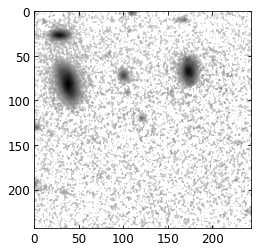

In [66]:
from astropy.visualization import simple_norm
from astropy.nddata import Cutout2D

position = (49.7, 100.1)
size = (244, 244)     # pixels

obj = np.random.randint(low=0,high=len(cat[1].data))
position = cat[1].data['X_image'][obj], cat[1].data['Y_image'][obj]
im = Cutout2D(field[0].data, position, size).data

norm = simple_norm(im, stretch='asinh', asinh_a=1e-3, min_cut=0)
plt.imshow(im, norm=norm, cmap='Greys')

In [334]:
def ObsRealism(
    inputName,
    candels_args={
        "candels_field": "GN",  # candels field
        "candels_ra": 236.1900,  # ra for image centroid
        "candels_dec": -0.9200,  # dec for image centroid
    },
):

    """
    Add realism to idealized unscaled image.
    """

    # img header and data
    with fits.open(inputName, mode="readonly") as hdul:
        # img header
        header = hdul[3].header
        # img data
        img_data = hdul[3].data

    # add image to real sdss sky
    """
    Extract field from galaxy survey database using
    effectively weighted by the number of galaxies in
    each field. For this to work, the desired field
    mask should already have been generated and the
    insertion location selected.
    """
    colc = candels_args["candels_colc"]
    rowc = candels_args["candels_rowc"]
    real_im = candels_args["candels_im"]

    # convert to integers
    colc, rowc = int(np.around(colc)), int(np.around(rowc))

    # add real sky pixel by pixel to image in nanomaggies
    corr_ny, corr_nx = real_im.shape
    ny, nx = img_data.shape

    for xx in range(nx):
        for yy in range(ny):
            corr_x = int(colc - nx / 2 + xx)
            corr_y = int(rowc - ny / 2 + yy)
            if (
                corr_x >= 0
                and corr_x <= corr_nx - 1
                and corr_y >= 0
                and corr_y <= corr_ny - 1
            ):
                img_data[yy, xx] += real_im[corr_y, corr_x]

    return img_data, real_im


"""
Script executions start here. This version grabs a corrected image
based on a basis set of galaxies from a database, runs source 
extractor to produce a mask, and selects the location in which to
place the image in the SDSS sky. The final science cutout includes
PSF blurring (real SDSS), SDSS sky from the corrected image, and 
Poisson noise added. The final image is in nanomaggies.
"""

# get field,column,row from database data
def rrcf_radec(field_info, input_dir, field_name=None, cutout_size=244):
    from astropy.wcs import WCS
    from astropy.nddata import Cutout2D

    if field_name is None:
        field_name = np.random.choice(list(field_info.keys()))

    catalog = fits.getdata(input_dir + "Catalogs/" + field_info[field_name][0], 1)
    field, field_header = fits.getdata(
        input_dir + "Fields/" + field_info[field_name][1], header=True
    )

    # randomly select from basis set
    print(field_name)
    #catalog = catalog[(catalog['FLAGS'] == 0) & (catalog['DEEP_SPEC_Z'] < 3) & (catalog['DEEP_SPEC_Z'] > 0.5)]
    index = np.random.randint(low=0, high=len(catalog) - 1)

    position = catalog["X_image"][index], catalog["Y_image"][index]
    size = (cutout_size, cutout_size)
    im = Cutout2D(field, position, size).data

    # convert to counts nanojanskies, where PHOTFNU is inverse sensitivity in units Jy*sec/electron
    im *= field_header["PHOTFNU"] * 1e9

    segmap = detect_sources(im)

    ## Run photutils

    # get info from mask header
    mask_nx, mask_ny = segmap.shape
    # define an initial pixel location by row,col
    colc = np.random.randint(low=int(0.1 * mask_nx), high=int(0.9 * mask_nx))
    rowc = np.random.randint(low=int(0.1 * mask_ny), high=int(0.9 * mask_ny))
    # iterate until the pixel location does not overlap with existing source
    while segmap[rowc, colc] != 0:
        colc = np.random.randint(low=int(0.1 * mask_nx), high=int(0.9 * mask_nx))
        rowc = np.random.randint(low=int(0.1 * mask_ny), high=int(0.9 * mask_ny))
    # get wcs mapping
    w = WCS(field_header)
    # determine ra,dec to prevent image registration offsets in each band
    ra, dec = w.wcs_pix2world(colc, rowc, 1, ra_dec_order=True)
    return field_name, ra, dec, colc, rowc, im


def make_candels_args(field_info, INPUT_DIR=""):
    field_name, ra, dec, colc, rowc, im = rrcf_radec(field_info, INPUT_DIR)
    candels_args = {
        "candels_field": field_name,  # candels field
        "candels_ra": ra,  # ra for image centroid
        "candels_dec": dec,  # dec for image centroid
        "candels_colc": colc,  # pixel x-coordinate for image centroid
        "candels_rowc": rowc,  # pixel y-coordinate for image centroid
        "candels_im": im,  # candels cutout
    }
    return candels_args


def detect_sources(image, PIXSIZE=0.13):
    import photutils
    from astropy.stats import gaussian_fwhm_to_sigma
    from astropy.convolution import Gaussian2DKernel

    # Run basic source detection

    # build kernel for pre-filtering.  How big?
    # don't assume redshift knowledge here
    typical_kpc_per_arcsec = 8.0

    kernel_kpc_fwhm = 5.0
    kernel_arcsec_fwhm = kernel_kpc_fwhm / typical_kpc_per_arcsec
    kernel_pixel_fwhm = kernel_arcsec_fwhm / PIXSIZE

    sigma = kernel_pixel_fwhm * gaussian_fwhm_to_sigma
    nsize = int(5 * kernel_pixel_fwhm)
    kernel = Gaussian2DKernel(sigma, x_size=nsize, y_size=nsize)

    bkg_estimator = photutils.MedianBackground()
    bkg = photutils.Background2D(image, (50, 50), bkg_estimator=bkg_estimator)
    thresh = bkg.background + (5.0 * bkg.background_rms)
    segmap_obj = photutils.detect_sources(
        image, thresh, npixels=10, filter_kernel=kernel
    )

    segmap_obj = photutils.deblend_sources(
        image, segmap_obj, npixels=10, filter_kernel=kernel, nlevels=32, contrast=0.01
    )

    segmap = segmap_obj.data

    return segmap


In [361]:
field[0].header

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                  -32  /  FITS BITS/PIXEL                              
NAXIS   =                    2  /  NUMBER OF AXES                               
NAXIS1  =                40800  /                                               
NAXIS2  =                12600  /                                               
FILENAME= 'hlsp_candels_hst_wfc3_egs-tot-60mas_f160w_v1.0_drz.fits' / MAST HLSP 
OBJECT  = 'EGS_ALL_WFC3_IR_F160W_060MAS_V1.1_DRZ[1/1]'                          
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '2014-07-22T15:14:41'                                                 
IRAFNAME= 'egs_all_wfc3_ir_f160w_060mas_v1.1_drz.hhh'  /  NAME OF IRAF IMAGE FIL
IRAF-MAX=           0.000000E0  /  DATA MAX                                     
IRAF-MIN=           0.000000E0  /  DATA MIN                                     
IRAF-BPX=                   

In [335]:
sim_im_name = '/home/ray/Research/AGN-Obscuration/data/orig_images/m0053.019.WFC3_F160W.image.SB25.0.fits'
candels_args = make_candels_args(field_info, INPUT_DIR)
new_im, real_im = ObsRealism(sim_im_name, candels_args)

COS
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [336]:
with fits.open(sim_im_name, mode="readonly") as hdul:
    old_im = hdul[3].data

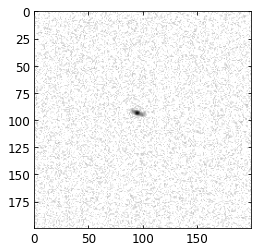

In [337]:
norm = simple_norm(old_im, stretch='asinh', asinh_a=1e-3, min_cut=0)
plt.imshow(old_im[156:356,156:356], norm=norm, cmap='Greys')

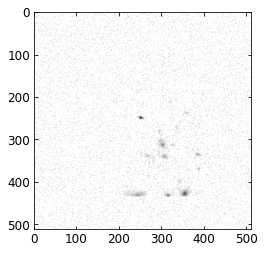

In [343]:
plt.imshow(new_im, norm=norm, cmap='Greys')

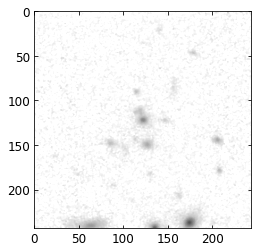

In [342]:
plt.imshow(real_im, norm=norm, cmap='Greys')